# Passo 1. Configuração do projeto

In [51]:
import joblib
import os

import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns 

import sklearn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report

# pacotes incluidos.
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

print('Matplot version: {}'.format(matplotlib.__version__))
print('Numpy version  : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version: {}'.format(sklearn.__version__))
print('Seaborn version: {}'.format(sns.__version__))


DATA_PATH = os.path.join('', '', '')
DATA_FILE = 'diabetes.csv'
DIABETES_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', 'model')
DEPLOY_FILE = 'finalized_model.sav'

RANDOM_STATE = 42

print('Configuração completa')


Matplot version: 3.3.2
Numpy version  : 1.19.2
Pandas version : 1.1.3
Sklearn version: 0.23.2
Seaborn version: 0.11.0
Configuração completa


# Passo 2. Carga de dados

In [52]:
def load_data(data_path, data_file):
    csv_path = os.path.join(data_path, data_file)
    return pd.read_csv(csv_path)

In [53]:
diabetes_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3. Análise exploratória de dados

In [54]:
print('Diabetes dataset tem {} linhas e {} colunas'.format(diabetes_data.shape[0], diabetes_data.shape[1]))

Diabetes dataset tem 768 linhas e 9 colunas


In [55]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


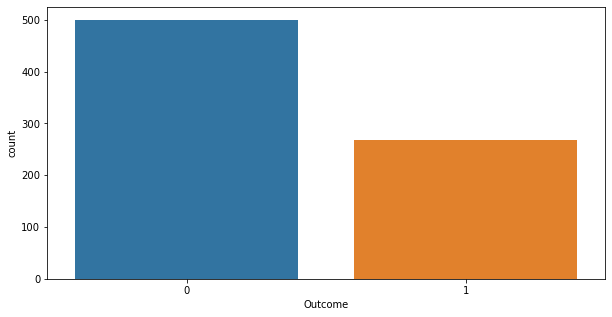

In [56]:
plt.figure(figsize=(10, 5))
_ = sns.countplot(x='Outcome', data=diabetes_data)

## Verificando valores nulos (NA)

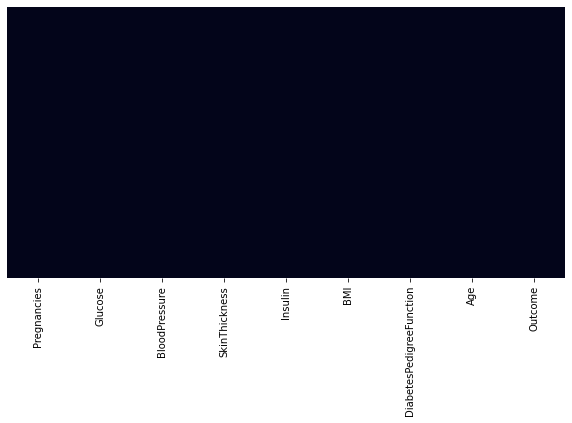

In [57]:
plt.figure(figsize=(10,5))
_ = sns.heatmap(diabetes_data.isnull(), yticklabels=False, cbar=False)

## Correlação e distribuição dos dados

In [58]:
X = diabetes_data.drop(['Outcome'], axis=1)
y = diabetes_data['Outcome']

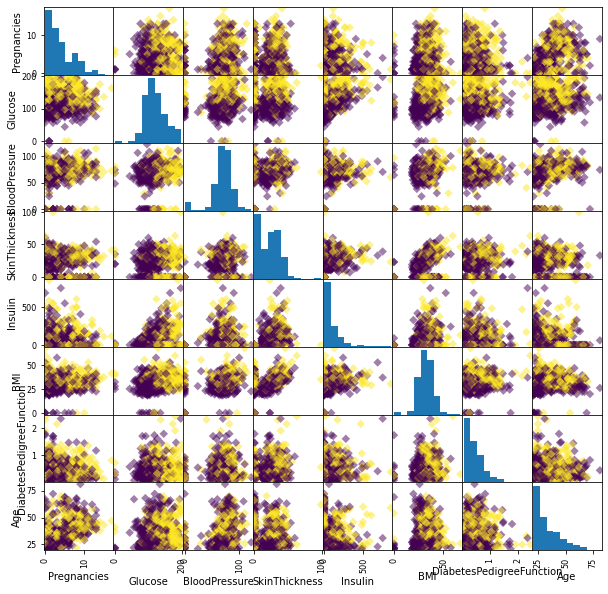

In [59]:
_ = pd.plotting.scatter_matrix(X, c=y, figsize=[10,10], marker='D')

# Passo 4. Preparação de dados

## 4.1 Amostragem aleatória

diabetes_amostra = diabetes_data.groupby('Outcome', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 4), random_state=42)
)
diabetes_amostra = diabetes_amostra.reset_index(drop=True)
diabetes_amostra

## 4.2 Tratamento de dados ausentes

### Identificação de dados ausentes

In [60]:
diabetes_data.tail(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
758,1,106,76,0,0,37.5,0.197,26,0
759,6,190,92,0,0,35.5,0.278,66,1
760,2,88,58,26,16,28.4,0.766,22,0
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [61]:
num_ausentes = (diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness'
                               , 'Insulin', 'BMI']] == 0).sum()
print('Quantidade de dados ausentes:\n{}'.format(num_ausentes))

Quantidade de dados ausentes:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


In [62]:
diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] =diabetes_data[
    ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)
diabetes_data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [63]:
for c in range(diabetes_data.shape[1]):
    ausentes   = diabetes_data[[diabetes_data.columns[c]]].isnull().sum()
    percentual = ausentes / diabetes_data.shape[0] * 100
    print ("> %s, ausentes: %d (%.2f%%)" % (diabetes_data.columns[c], ausentes, percentual) )

> Pregnancies, ausentes: 0 (0.00%)
> Glucose, ausentes: 5 (0.65%)
> BloodPressure, ausentes: 35 (4.56%)
> SkinThickness, ausentes: 227 (29.56%)
> Insulin, ausentes: 374 (48.70%)
> BMI, ausentes: 11 (1.43%)
> DiabetesPedigreeFunction, ausentes: 0 (0.00%)
> Age, ausentes: 0 (0.00%)
> Outcome, ausentes: 0 (0.00%)


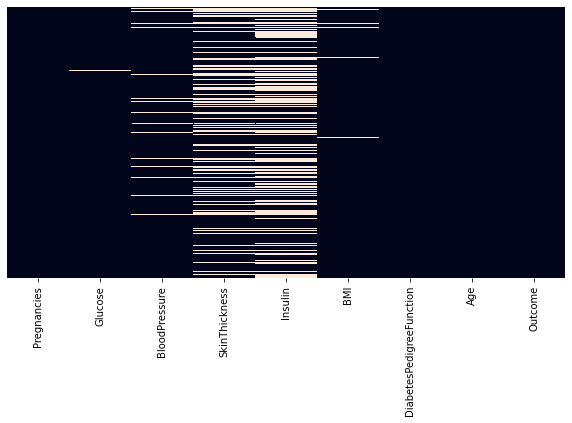

In [64]:
plt.figure(figsize=(10,5))
_ = sns.heatmap(diabetes_data.isnull(), yticklabels=False, cbar=False)

### Remocao e Imputação de dados ausentes


In [65]:
diabetes_data.drop(['Insulin'], axis=1, inplace=True)

In [66]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']] = imputer.fit_transform(
    diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']].values
)

In [67]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,67.100000,2.420000,81.000000,1.000000


## Passo 5. Transformação de dados

In [68]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

X = diabetes_data.drop(['Outcome'], axis=1)
y = diabetes_data['Outcome']

scaler = MinMaxScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

#scaler = StandardScaler() 
#X_scaled = pd.DataFrame(scaler.fit_transform(X))
#X_scaled.columns = X.columns

In [69]:
X_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.670968,0.489796,0.304348,0.314928,0.234415,0.483333
1,0.058824,0.264516,0.428571,0.239130,0.171779,0.116567,0.166667
2,0.470588,0.896774,0.408163,0.240798,0.104294,0.253629,0.183333
3,0.058824,0.290323,0.428571,0.173913,0.202454,0.038002,0.000000
4,0.000000,0.600000,0.163265,0.304348,0.509202,0.943638,0.200000


# Passo 6. Particionamento do dataset

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=.3, random_state=RANDOM_STATE)

# Passo 7. Treinamento do modelo

In [71]:
def build_classifiers():
    """Retorna uma lista com os classificadores que serão avaliados"""
    
    classifiers=[]
    classifiers.append(
        ('knn',                  # nome do classificador.
         KNeighborsClassifier(), # instancia do classificador.
         {'n_neighbors': range(1, 33, 2)} # hyperparametros.
        )
    )
    
    classifiers.append(
        ('lr',                  # nome do classificador.
         LogisticRegression(max_iter=1000), # instancia do classificador.
         {'penalty': ['l2'], 'C': [100, 10, 1, 0.1, 0.01]} # hyperparametros.
        )
    )
    
    classifiers.append(
        ('svm',                  # nome do classificador.
         SVC(), # instancia do classificador.
         {'kernel': ['linear', 'rbf'], 
          'C': [2**(-5), 1, 2**5, 2**10],
          'gamma': [2**(-15), 2**(-10), 2**(-5), 1, 2**5]
         } # hyperparametros.
        )
    )
    
    classifiers.append(
        ('dt',                  # nome do classificador.
         DecisionTreeClassifier(), # instancia do classificador.
         {'max_depth': [2, 4, 6, 8, 10, 12]} # hyperparametros.
        )
    )
    
    classifiers.append(
        ('rf',                  # nome do classificador.
         RandomForestClassifier(), # instancia do classificador.
         {'n_estimators': [10, 50, 100]} # hyperparametros.
        )
    )
    
    return classifiers

In [76]:
classifiers = build_classifiers()
results = []
names   = []

for name, model, parameters in classifiers:
    print('>> classifier name: {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv = cross_val_score(gs, X_train, y_train, cv=kfold, scoring='accuracy')
    print('Mean: {}, Standard Deviation: {}'.format(cv.mean(), cv.std()))
    results.append(cv)
    names.append(name)
    # TODO: guardar a estatistica de teste para plotar um gráfico de barras.

>> classifier name: knn
Mean: 0.759958071278826, Standard Deviation: 0.04427347802332192
>> classifier name: lr
Mean: 0.7693221523410203, Standard Deviation: 0.06254285591051935
>> classifier name: svm
Mean: 0.7711390635918937, Standard Deviation: 0.06424663515477919
>> classifier name: dt
Mean: 0.730083857442348, Standard Deviation: 0.04761680949486245
>> classifier name: rf
Mean: 0.7674004192872117, Standard Deviation: 0.04245104717406677


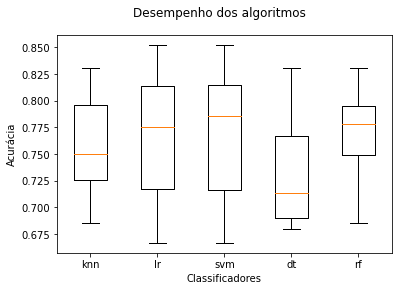

In [81]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')
plt.show()

Os dois melhores algortimos são o LR e SVM